In [2]:
pip install opencv-python

In [10]:
# Import

import tensorflow as tf
import os
import numpy as np
import cv2
import random
from PIL import Image
import shutil
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.src.metrics.confusion_metrics import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Activation
from tensorflow.keras.models import load_model

In [11]:
#Reading data

data_dir = './vegetables_fruits_data/'
train_folder = os.path.join(data_dir, 'train')
valid_folder = os.path.join(data_dir, 'validation')
test_folder = os.path.join(data_dir, 'test')
print(os.listdir(data_dir))
Cclasses = os.listdir(test_folder)
Cclasses

['test', 'train', 'validation']


['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [12]:
#deleting corrupted files

def filter_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                try:

                    with Image.open(file_path) as img:
                        img.verify()
                except OSError:

                    print(f"Removing: {file_path}")
                    os.remove(file_path)
            else:

                print(f"Removing: {file_path} - Unsupported file type")
                os.remove(file_path)

filter_images(test_folder)
filter_images(train_folder)
filter_images(valid_folder)

Implementing some calculation functions to view the number of files in folder so we can decide if we should use oversample or undersample

In [13]:
# Function to count the number of files in a folder
def count_files(folder_path):
    try:
        with os.scandir(folder_path) as entries:
            return sum(1 for entry in entries if entry.is_file() and not entry.name.startswith('.'))
    except OSError as e:
        print(f"Error counting files in {folder_path}: {e}")
        return 0

# Function to calculate the percentage of files in a folder
def calculate_percentage(folder_path, total_files):
    folder_files = count_files(folder_path)
    return (folder_files / total_files) * 100 if total_files > 0 else 0

# Iterate through test, train, and valid folders
for folder in [test_folder, train_folder, valid_folder]:
    total_files = sum([count_files(os.path.join(folder, class_name)) for class_name in Cclasses])

    print(f"Folder: {folder}")
    for class_name in Cclasses:
        class_folder = os.path.join(folder, class_name)
        class_count = count_files(class_folder)
        class_percentage = calculate_percentage(class_folder, total_files)
        print(f"  Class: {class_name} - Count: {class_count} - Percentage: {class_percentage:.2f}%")

    print(f"  Total Files: {total_files}")
    print()

Folder: ./vegetables_fruits_data/test
  Class: apple - Count: 10 - Percentage: 2.79%
  Class: banana - Count: 9 - Percentage: 2.51%
  Class: beetroot - Count: 10 - Percentage: 2.79%
  Class: bell pepper - Count: 10 - Percentage: 2.79%
  Class: cabbage - Count: 10 - Percentage: 2.79%
  Class: capsicum - Count: 10 - Percentage: 2.79%
  Class: carrot - Count: 10 - Percentage: 2.79%
  Class: cauliflower - Count: 10 - Percentage: 2.79%
  Class: chilli pepper - Count: 10 - Percentage: 2.79%
  Class: corn - Count: 10 - Percentage: 2.79%
  Class: cucumber - Count: 10 - Percentage: 2.79%
  Class: eggplant - Count: 10 - Percentage: 2.79%
  Class: garlic - Count: 10 - Percentage: 2.79%
  Class: ginger - Count: 10 - Percentage: 2.79%
  Class: grapes - Count: 10 - Percentage: 2.79%
  Class: jalepeno - Count: 10 - Percentage: 2.79%
  Class: kiwi - Count: 10 - Percentage: 2.79%
  Class: lemon - Count: 10 - Percentage: 2.79%
  Class: lettuce - Count: 10 - Percentage: 2.79%
  Class: mango - Count: 10 -

In [18]:
# Training generator + Augmentation

basic_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)

train_data = train_gen.flow_from_directory(
    train_folder,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

valid_data = basic_gen.flow_from_directory(
    valid_folder,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

test_data = basic_gen.flow_from_directory(
    test_folder,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True
)


Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [19]:
#building model

input_shape=(224,224,3)

base_model = EfficientNetB0(
    include_top=False, 
    weights="imagenet", 
    input_shape=input_shape 
    )

#freezing layers to use the model as feature extractor
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(36,activation = 'softmax'))
model.summary()

#Compiling the model
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 1280)        5120      
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 1280)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 11520)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              11797504  
                                                      

In [25]:
#Training the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr
]
results = model.fit(train_data, validation_data=valid_data, epochs=10, verbose=1)


Epoch 1/10
98/98 [==============================] - 147s 1s/step - loss: 0.9075 - accuracy: 0.7095 - val_loss: 0.3304 - val_accuracy: 0.8718
Epoch 2/10
98/98 [==============================] - 149s 2s/step - loss: 0.8566 - accuracy: 0.7396 - val_loss: 0.3364 - val_accuracy: 0.8718
Epoch 3/10
98/98 [==============================] - 148s 2s/step - loss: 0.8581 - accuracy: 0.7323 - val_loss: 0.3628 - val_accuracy: 0.8661
Epoch 4/10
98/98 [==============================] - 151s 2s/step - loss: 0.7901 - accuracy: 0.7419 - val_loss: 0.3139 - val_accuracy: 0.8689
Epoch 5/10
98/98 [==============================] - 138s 1s/step - loss: 0.7897 - accuracy: 0.7515 - val_loss: 0.3667 - val_accuracy: 0.8462
Epoch 6/10
98/98 [==============================] - 149s 2s/step - loss: 0.7882 - accuracy: 0.7496 - val_loss: 0.2879 - val_accuracy: 0.8718
Epoch 7/10
98/98 [==============================] - 152s 2s/step - loss: 0.7433 - accuracy: 0.7525 - val_loss: 0.2941 - val_accuracy: 0.8718
Epoch 8/10
98

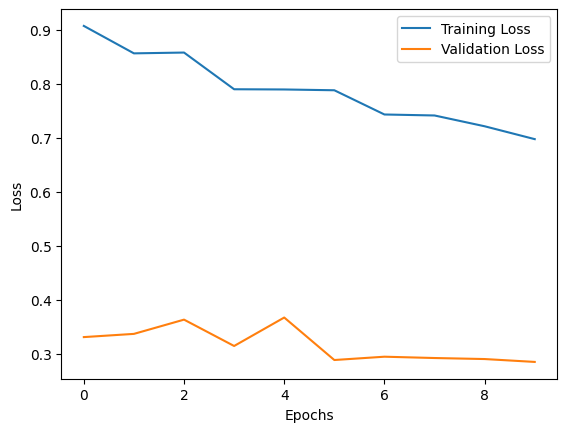

In [26]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Plot training progress
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Get the current working directory
current_directory = os.getcwd()

# Set the path where we want to save the model (current working directory)
save_path = os.path.join(current_directory, 'model_checkpoint.h5')

# Save the model
model.save(save_path)

C:\Users\ranim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
image_recognize = load_model(save_path)

In [32]:
loss, acc = image_recognize.evaluate(test_data,verbose = 1)

12/12 [==============================] - 15s 1s/step - loss: 0.2842 - accuracy: 0.8942
